### Plan
1. Load data for phenotype classification task [done]
2. Add blur to images
	- Extract traditional features using the R code
	- Extract CL features
3. Train classifiers using the extracted features and CL features
4. Evaluate the results and store them together with experiment conditions
5. Visualize the results


In [1]:
# Load modules
import sys
import subprocess
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision import transforms
# import os
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import sys

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../.."))
sys.path.append(project_root)

from src.representation_learning.data_loader import CustomImageDataset
from src.representation_learning.model_cl import CL 
from src.utils import utils

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = 'cuda:0'


In [2]:
# Load data
data_path = '/mnt/deepstore/LBxPheno/figures/figure2/data_dropped_NAN_CECs' #change to the new data directory
dataloader, images, masks, labels = utils.get_data_loaders(data_path, batch_size=512)

['Large_Nuclear', 'CTCs', 'IM_CTC', 'PC_CTCs', 'Megakaryocytes', 'CECs', 'Large_Vimentin']
Large_Nuclear
CTCs
IM_CTC
PC_CTCs
Megakaryocytes
CECs
Large_Vimentin
(2166, 75, 75, 4) (2166, 75, 75, 1) (2166,)


In [3]:
# # Load model

model_path = '/mnt/deepstore/LBxPheno/pipeline/model_weights/representation_learning_04_28.pth'
model = CL(in_channels=5, h_dim=128, projection_dim=64)
state_dict = torch.load(model_path)['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
model.to(device)

CL(
  (encoder): Encoder(
    (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adap_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=256, out_features=128, bias=True)
  )
  (projector): Sequential(
    (0): Linear(in_features=128, out_features=128, bia

In [4]:
# add blur to images and extract CL features
sigmas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
for s in sigmas:
	# setup the filter
	if s != 0:
		blur = transforms.GaussianBlur(kernel_size=(5,5), sigma=s)
	blurred_images = []

	# add blur to images
	for image in images:
		if s != 0:
			blurred_image = blur(torch.from_numpy(image))
		else:
			blurred_image = torch.from_numpy(image)
		blurred_images.append(blurred_image.numpy().astype('uint16'))
	blurred_images = np.stack(blurred_images, axis=0)

	# extract the CL features
	# previous setting
	dataset = CustomImageDataset(blurred_images, masks, labels)


	dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(images), shuffle=False)

	#previous setting
	CL_features = utils.get_embeddings(model, dataloader, device)

	CL_features = CL_features.numpy()

	CL_features = pd.DataFrame(
		CL_features.astype('float32'), #needs to be float32 instead of float16
		columns=[f'z{i}' for i in range(CL_features.shape[1])])
	CL_features.to_csv(f'robustness_test/blurred_sigma_{s}_CL_feat.txt', sep='\t', index=False)

	# store blurred images for traditional features
	utils.save_5channel_tiffs_single_file(blurred_images, masks, f'robustness_test/blurred_sigma_{s}.tif')

Saved multi-page TIFF: robustness_test/blurred_sigma_0.0.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_0.1.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_0.2.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_0.3.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_0.4.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_0.5.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_0.75.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_1.0.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_1.25.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_1.5.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_2.0.tif
Saved multi-page TIFF: robustness_test/blurred_sigma_3.0.tif


In [5]:
# extract traditional features
processes = []
for s in sigmas:
	process = subprocess.Popen([
		'Rscript',
		'/mnt/deepstore/LBxPheno/src/utils/extractEBImageFeaturesArray.R',
		f'robustness_test/blurred_sigma_{s}.tif',
		f'robustness_test/blurred_sigma_{s}_trad_feat.txt'])
	processes.append(process)
	

[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No cell features"
[1] "No nucleus features"
[1] "No cell featur

In [6]:
# filtered columns for traditional features
trad_feat = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')
trad_feat.drop(columns=['image_name'], inplace=True)
print('before filtering:', trad_feat.shape[1])
cols = trad_feat.columns
cellf_cols = [c for c in cols if c.startswith('cellf.')]
nucleusf_cols = [c for c in cols if c.startswith('nucleusf.')]
cols = [c for c in cols if not c.endswith('.cx')]
cols = [c for c in cols if not c.endswith('.cy')]
cols = [c for c in cols if not 'theta' in c]
cols = [c for c in cols if not 'nucleus_cell_dist' in c]
cols = [c for c in cols if not 'cell_nucleus_ratio' in c]
cols = [c for c in cols if not 'tritc_cy5_ratio' in c]
cols = [c for c in cols if not c.startswith('nucleusf.')] # cellf.dapi
cols = [c for c in cols if not c.startswith('cellf.B')] # dapi
print('after filtering:', len(cols))


before filtering: 883
after filtering: 368


In [7]:
# Classify cells with features
sigmas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5]#, 2.0, 3.0]
CL_feat_control = pd.read_table('robustness_test/blurred_sigma_0.0_CL_feat.txt')
trad_feat_control = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')[cols]

all_results = []
for s in sigmas:
	condition = f'blurred_sigma_{s}'
	# load traditional features
	trad_feat = pd.read_table(f'robustness_test/{condition}_trad_feat.txt')
	
	zero_cellf = trad_feat[cellf_cols].apply(lambda x: (x != 0).sum(), axis=1)
	zero_nucleusf = trad_feat[nucleusf_cols].apply(lambda x: (x != 0).sum(), axis=1)
	filter_indices = np.where(zero_cellf == 0)[0].tolist()
	filter_indices.extend(np.where(zero_nucleusf == 0)[0].tolist())
	print(s, len(filter_indices))
	trad_feat = trad_feat[cols]
	
	# load CL features
	embeddings_df = pd.read_table(f'robustness_test/{condition}_CL_feat.txt')
	embeddings_df = embeddings_df.drop(index=filter_indices).reset_index(drop=True)
	trad_feat = trad_feat.drop(index=filter_indices).reset_index(drop=True)
	curr_labels = np.delete(labels, filter_indices, axis=0)
	curr_trad_control = trad_feat_control.drop(index=filter_indices).reset_index(drop=True)
	curr_CL_control = CL_feat_control.drop(index=filter_indices).reset_index(drop=True)

	#length of data
	n = len(curr_labels)


	
	#randomly sample 80% of the data (random state 42)
	np.random.seed(42)
	train_indices = np.random.choice(n, int(0.8*n), replace=False)
	test_indices = np.array([i for i in range(n) if i not in train_indices])

	#split the data
	train_labels = np.concatenate((np.zeros(len(train_indices), dtype=int), np.ones(len(train_indices), dtype=int)))
	test_labels = np.concatenate((np.zeros(len(test_indices), dtype=int), np.ones(len(test_indices), dtype=int)))

	######
	scaler = StandardScaler()
	temp = pd.concat([curr_CL_control, embeddings_df]).reset_index(drop=True)
	CL_feat_scaled = scaler.fit_transform(temp)
	train_embeddings = CL_feat_scaled[np.concatenate((train_indices, train_indices + n))]
	test_embeddings = CL_feat_scaled[np.concatenate((test_indices, test_indices + n))]
	######
	
	scaler = StandardScaler()
	temp = pd.concat([curr_trad_control, trad_feat], axis=0).reset_index(drop=True)
	trad_feat_scaled = scaler.fit_transform(temp)
	train_traditional = trad_feat_scaled[np.concatenate((train_indices, train_indices + n))]
	test_traditional = trad_feat_scaled[np.concatenate((test_indices, test_indices + n))]

	pca = PCA(n_components=128)
	pca.fit(trad_feat_scaled)
	trad_feat_pca = pca.transform(trad_feat_scaled)
	train_traditional_pca = trad_feat_pca[np.concatenate((train_indices, train_indices + n))]
	test_traditional_pca = trad_feat_pca[np.concatenate((test_indices, test_indices + n))]


	#train on CL embeddings
	clf = LogisticRegression(max_iter=5000, random_state=42)
	clf.fit(train_embeddings, train_labels)
	preds = clf.predict(test_embeddings)

	#print accuracy, precision, recall, f1 for the dataset
	# print('CL Embeddings')

	# print('Accuracy:', accuracy_score(test_labels, preds))
	# print('Precision:', precision_score(test_labels, preds, average='weighted'))
	# print('Recall:', recall_score(test_labels, preds, average='weighted'))
	# print('F1:', f1_score(test_labels, preds, average='weighted'))

	#train on traditional features
	clf2 = LogisticRegression(max_iter=5000, random_state=42)
	clf2.fit(train_traditional, train_labels)
	preds2 = clf2.predict(test_traditional)

	#print accuracy, precision, recall, f1 for the dataset

	# print('Traditional Features')
	# print('Accuracy:', accuracy_score(test_labels, preds2))
	# print('Precision:', precision_score(test_labels, preds2, average='weighted'))
	# print('Recall:', recall_score(test_labels, preds2, average='weighted'))
	# print('F1:', f1_score(test_labels, preds2, average='weighted'))

	#train on traditional features (PCA)
	clf3 = LogisticRegression(max_iter=5000, random_state=42)
	clf3.fit(train_traditional_pca, train_labels)
	preds3 = clf3.predict(test_traditional_pca)

	#print accuracy, precision, recall, f1 for the dataset

	# print('Traditional Features (PCA)')
	# print('Accuracy:', accuracy_score(test_labels, preds3))
	# print('Precision:', precision_score(test_labels, preds3, average='weighted'))
	# print('Recall:', recall_score(test_labels, preds3, average='weighted'))
	# print('F1:', f1_score(test_labels, preds3, average='weighted'))

	# save results
	results = pd.DataFrame({
		'n': [n],
		'condition': [condition],
		'sigma': [s],
		'CL_Accuracy': [accuracy_score(test_labels, preds)],
		'CL_Precision': [precision_score(test_labels, preds, average='macro')],
		'CL_Recall': [recall_score(test_labels, preds, average='macro')],
		'CL_F1': [f1_score(test_labels, preds, average='macro')],
		
		'Trad_Accuracy': [accuracy_score(test_labels, preds2)],
		'Trad_Precision': [precision_score(test_labels, preds2, average='macro')],
		'Trad_Recall': [recall_score(test_labels, preds2, average='macro')],
		'Trad_F1': [f1_score(test_labels, preds2, average='macro')],
		
		'TradPCA_Accuracy': [accuracy_score(test_labels, preds3)],
		'TradPCA_Precision': [precision_score(test_labels, preds3, average='macro')],
		'TradPCA_Recall': [recall_score(test_labels, preds3, average='macro')],
		'TradPCA_F1': [f1_score(test_labels, preds3, average='macro')]
	})

	# print(results)
	all_results.append(results)

0.0 13


/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

0.1 13


/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

0.2 13


/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.3 13
0.4 6
0.5 4
0.75 3
1.0 3
1.25 3
1.5 3


In [8]:
all_results = pd.concat(all_results)
all_results.reset_index(drop=True, inplace=True)

In [9]:
all_results

,n,condition,sigma,CL_Accuracy,CL_Precision,CL_Recall,CL_F1,Trad_Accuracy,Trad_Precision,Trad_Recall,Trad_F1,TradPCA_Accuracy,TradPCA_Precision,TradPCA_Recall,TradPCA_F1
0,2154,blurred_sigma_0.0,0.00,0.500000,0.250000,0.500000,0.333333,0.500000,0.250000,0.500000,0.333333,0.500000,0.250000,0.500000,0.333333
1,2154,blurred_sigma_0.1,0.10,0.500000,0.250000,0.500000,0.333333,0.500000,0.250000,0.500000,0.333333,0.500000,0.250000,0.500000,0.333333
2,2154,blurred_sigma_0.2,0.20,0.500000,0.250000,0.500000,0.333333,0.501160,0.501161,0.501160,0.501093,0.500000,0.500000,0.500000,0.498379
3,2154,blurred_sigma_0.3,0.30,0.581206,0.582866,0.581206,0.579099,0.728538,0.737562,0.728538,0.725936,0.720418,0.730702,0.720418,0.717267
4,2161,blurred_sigma_0.4,0.40,0.766744,0.771281,0.766744,0.765764,0.915704,0.916684,0.915704,0.915655,0.907621,0.908877,0.907621,0.907550
5,2163,blurred_sigma_0.5,0.50,0.852194,0.858629,0.852194,0.851528,0.958430,0.958439,0.958430,0.958429,0.959584,0.959587,0.959584,0.959584
6,2164,blurred_sigma_0.75,0.75,0.935335,0.939470,0.935335,0.935182,0.988453,0.988619,0.988453,0.988452,0.986143,0.986309,0.986143,0.986142
7,2164,blurred_sigma_1.0,1.00,0.954965,0.957309,0.954965,0.954908,0.995381,0.995423,0.995381,0.995381,0.995381,0.995423,0.995381,0.995381
8,2164,blurred_sigma_1.25,1.25,0.965358,0.966792,0.965358,0.965331,0.996536,0.996538,0.996536,0.996536,0.996536,0.996538,0.996536,0.996536
9,2164,blurred_sigma_1.5,1.50,0.967667,0.968878,0.967667,0.967647,0.998845,0.998848,0.998845,0.998845,0.998845,0.998848,0.998845,0.998845


In [10]:
# convert wide to long format 
all_results_long = pd.melt(all_results,
	id_vars=['n', 'condition', 'sigma'],
	var_name='FeatureType', value_name='value').reset_index()

In [11]:
# create two columns by splitting FeatureType with '_'
all_results_long[['Feature', 'Metric']] = all_results_long['FeatureType'].str.split('_', expand=True)

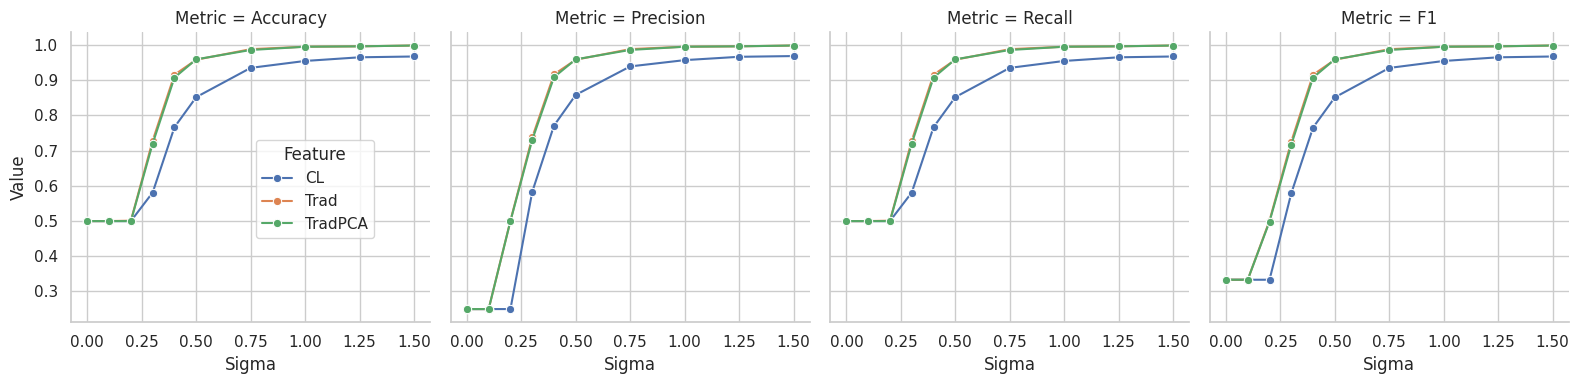

In [12]:
# plot sigma vs value for all_results_long with Feature as hue and facet on metric
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
g = sns.FacetGrid(all_results_long, col='Metric', hue='Feature', height=4, aspect=1)
g.map(sns.lineplot, 'sigma', 'value', marker='o')
g.add_legend(loc='upper right', frameon=True, bbox_to_anchor=(0.23, 0.65))
g.set_axis_labels('Sigma', 'Value')
# g.set_titles(col_template="{col_name}")
plt.savefig('robustness_test/GaussianBlur_robustness_test_results_binary.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)
(2166, 128) (2166, 128)


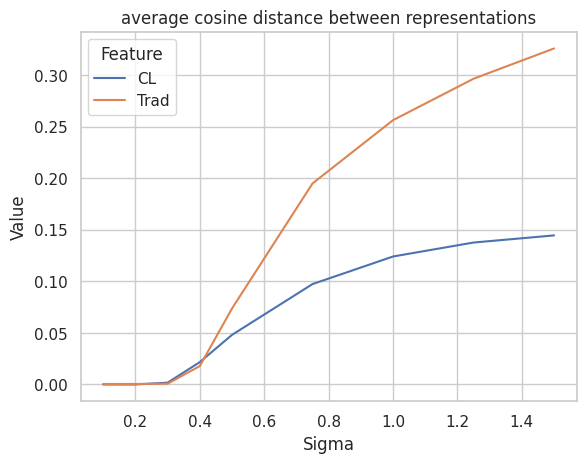

In [13]:
# measuring the shift in representation space
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

cos_dist_results = {'Sigma':[], 'Feature':[], 'Value':[]}
# Load Data
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5]#, 2.0, 3.0]
for s in sigmas:
    emb_orig = pd.read_table('robustness_test/blurred_sigma_0.0_CL_feat.txt')
    emb_blur = pd.read_table(f'robustness_test/blurred_sigma_{s}_CL_feat.txt')
    feat_orig = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')
    feat_blur = pd.read_table(f'robustness_test/blurred_sigma_{s}_trad_feat.txt')

    print(emb_orig.shape, emb_blur.shape)

    cos_dist_results['Sigma'].append(s)
    cos_dist_results['Feature'].append('CL')
    cos_dist_results['Value'].append(np.diagonal(cosine_distances(
        emb_orig.values,#.drop(index=filter_indices).reset_index(drop=True).values,
        emb_blur.values#.drop(index=filter_indices).reset_index(drop=True).values
        )).mean())
    cos_dist_results['Sigma'].append(s)
    cos_dist_results['Feature'].append('Trad')
    cos_dist_results['Value'].append(np.diagonal(cosine_distances(
        feat_orig[cols].values,#.drop(index=filter_indices).reset_index(drop=True).values,
        feat_blur[cols].values#.drop(index=filter_indices).reset_index(drop=True).values
        )).mean())

cos_dist_results = pd.DataFrame(cos_dist_results)
sns.lineplot(x='Sigma', y='Value', hue='Feature', data=cos_dist_results)
plt.title('average cosine distance between representations')
plt.show()


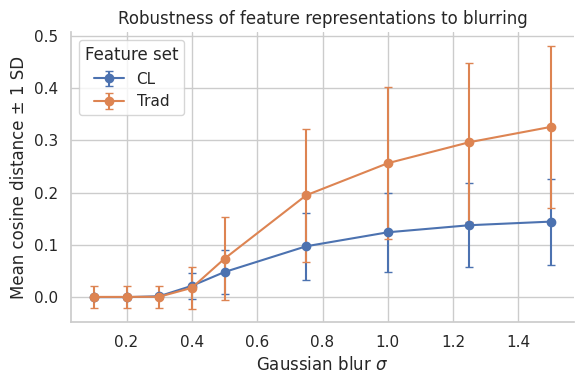

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances

cos_dist_results = {'Sigma': [], 'Feature': [], 'Mean': [], 'Std': []}

sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5]

for s in sigmas:
    # --- load once per sigma ---
    emb_orig  = pd.read_table('robustness_test/blurred_sigma_0.0_CL_feat.txt')
    emb_blur  = pd.read_table(f'robustness_test/blurred_sigma_{s}_CL_feat.txt')
    feat_orig = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')
    feat_blur = pd.read_table(f'robustness_test/blurred_sigma_{s}_trad_feat.txt')

    # --------- CL features ----------
    dists_cl = np.diagonal(cosine_distances(emb_orig.values,
                                            emb_blur.values))
    cos_dist_results['Sigma'].append(s)
    cos_dist_results['Feature'].append('CL')
    cos_dist_results['Mean'].append(dists_cl.mean())
    cos_dist_results['Std'].append(dists_cl.std(ddof=1))   # sample std

    # --------- traditional features ----------
    dists_trad = np.diagonal(cosine_distances(feat_orig[cols].values,
                                              feat_blur[cols].values))
    cos_dist_results['Sigma'].append(s)
    cos_dist_results['Feature'].append('Trad')
    cos_dist_results['Mean'].append(dists_trad.mean())
    cos_dist_results['Std'].append(dists_trad.std(ddof=1))

cos_dist_results = pd.DataFrame(cos_dist_results)

# ------------------ plot ------------------
fig, ax = plt.subplots(figsize=(6,4))
for feat, grp in cos_dist_results.groupby('Feature'):
    ax.errorbar(grp['Sigma'], grp['Mean'], yerr=grp['Std'],
                marker='o', capsize=3, label=feat)

ax.set_xlabel(r'Gaussian blur $\sigma$')
ax.set_ylabel('Mean cosine distance ± 1 SD')
ax.set_title('Robustness of feature representations to blurring')
ax.legend(title='Feature set')
sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
# Assume you have frame_paths_list = list of [ch1_path, ch2_path, ..., chN_path] per frame
from slideutils.utils.utils import generate_tile_paths

slidepath = "/mnt/csidata/OncoScope/tubeID_0AD1C/exptID_15523/slideID_0AD1C10/bzScanner/proc"

frame_ids = list(range(100,200))
frame_paths_list = [generate_tile_paths(slidepath, i, [1,2305,4609,9217], ["Tile%06d.tif"]) for i in frame_ids]

params = {
    "intensity_threshold": 30000,
    "size_threshold": 15,
    "tile_size": 45,
    "extract_tiles": True,
    "channels": ["DAPI", "TRITC", "CY5", "FITC"]
}

frames = load_frames_parallel(zip(frame_ids, frame_paths_list))


In [15]:
import numpy as np

def fdr_bh(pvals):
    """
    Benjamini–Hochberg FDR correction (independent or positively-correlated tests).
    Returns q-values in the **original order**.
    """
    pvals = np.asarray(pvals, dtype=float)
    n     = pvals.size

    order = np.argsort(pvals)                  # indices that sort p ascending
    ranked = pvals[order]

    q = ranked * n / np.arange(1, n + 1)       # raw BH adjustment
    q = np.minimum.accumulate(q[::-1])[::-1]   # enforce monotone increase
    q = np.clip(q, 0, 1)                       # keep inside [0, 1]

    q_corrected = np.empty_like(q)
    q_corrected[order] = q                     # back-map to original order
    return q_corrected


 Sigma  Mann-Whitney U         p         q
   0.5        1.69e+06  1.61e-56  1.61e-56
  0.75        1.06e+06 4.37e-215 5.46e-215
     1        9.43e+05 1.09e-254 1.81e-254
  1.25        8.28e+05 8.91e-298 2.23e-297
   1.5        7.24e+05         0         0


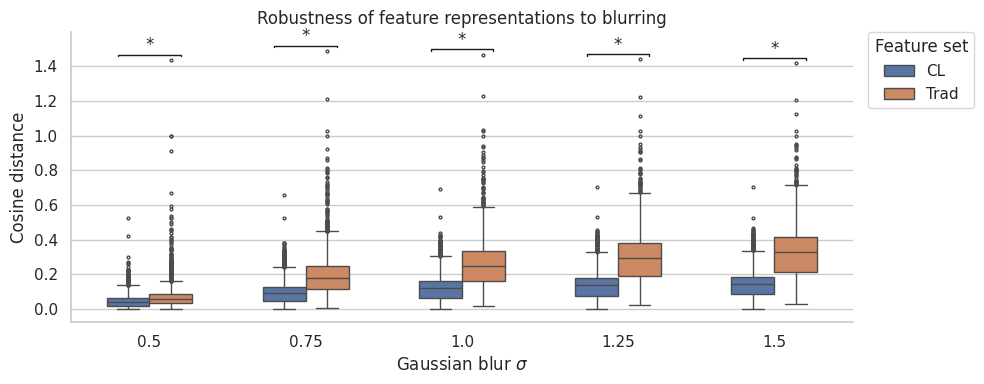

In [16]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import mannwhitneyu          # <-- changed import

# ---------- collect per-sample distances ----------
records = []
sigmas  = [0.5, 0.75, 1.0, 1.25, 1.5]

for s in sigmas:
    emb_orig  = pd.read_table('robustness_test/blurred_sigma_0.0_CL_feat.txt')
    emb_blur  = pd.read_table(f'robustness_test/blurred_sigma_{s}_CL_feat.txt')
    feat_orig = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')
    feat_blur = pd.read_table(f'robustness_test/blurred_sigma_{s}_trad_feat.txt')

    d_cl   = np.diagonal(cosine_distances(emb_orig.values,        emb_blur.values))
    d_trad = np.diagonal(cosine_distances(feat_orig[cols].values, feat_blur[cols].values))

    records += [{'Sigma': s, 'Feature': 'CL',   'Dist': d} for d in d_cl]
    records += [{'Sigma': s, 'Feature': 'Trad', 'Dist': d} for d in d_trad]

dist_df = pd.DataFrame(records)
dist_df['Sigma_cat'] = dist_df['Sigma'].astype(str)
order = [str(s) for s in sigmas]

# ---------- independent Mann-Whitney tests ----------
stats_rows = []
for s in sigmas:
    d_cl   = dist_df.query("Sigma == @s & Feature == 'CL'")['Dist'].values
    d_trad = dist_df.query("Sigma == @s & Feature == 'Trad'")['Dist'].values

    u_stat, p = mannwhitneyu(d_cl, d_trad, alternative='two-sided')
    stats_rows.append({'Sigma': s, 'Mann-Whitney U': u_stat, 'p': p})

stats_df = pd.DataFrame(stats_rows)
stats_df['q'] = fdr_bh(stats_df['p'].values)     # same BH correction function

print(stats_df.to_string(index=False, float_format="%.3g"))

# ---------- boxplot ----------
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='Sigma_cat', y='Dist', hue='Feature',
                 data=dist_df, order=order, width=0.55, dodge=True,
                 showcaps=True, fliersize=2, linewidth=1)
ax.set_xlabel(r'Gaussian blur $\sigma$')
ax.set_ylabel('Cosine distance')
ax.set_title('Robustness of feature representations to blurring')
sns.despine()

# ---------- annotate significance ----------
y_max = dist_df.groupby(['Sigma_cat','Feature'])['Dist'].max().unstack().max(axis=1)
box_width = 0.4
for idx, s in enumerate(order):
    q_val = stats_df.loc[stats_df['Sigma']==float(s), 'q'].iloc[0]
    if q_val < 0.001:
        x1, x2 = idx - box_width/2, idx + box_width/2
        y = y_max[s] + 0.02
        ax.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], lw=1, c='k')
        ax.text((x1+x2)/2, y+0.012, '*', ha='center', va='bottom', fontsize=12)

ax.legend(title='Feature set', bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.tight_layout()
plt.show()
